<a href="https://colab.research.google.com/github/mridulCSE98/CVPR/blob/main/MobileNetCompFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_set_path = '/content/drive/MyDrive/cat_dog_panda'

In [4]:
SEED = 42
IMG_SIZE = 224
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16

In [5]:
train_gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range=[0.8, 1.2],
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    brightness_range=[0.8, 1.2],
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
)

In [6]:
train_batch = train_gen.flow_from_directory(
  directory =  data_set_path,
  target_size = (IMG_SIZE,IMG_SIZE),
  batch_size = TRAIN_BATCH_SIZE,
  class_mode = 'sparse',
  seed = SEED,
  subset='training'
)

val_batch = train_gen.flow_from_directory(
  directory=data_set_path,
  target_size=(IMG_SIZE, IMG_SIZE),
  batch_size=VAL_BATCH_SIZE,
  class_mode='sparse',
  seed=SEED,
  subset='validation'
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


# MobileNet V1

In [7]:
def MobileNetV1(input_shape=(224, 224, 3), num_classes=3):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Conv Layer (standard convolution)
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=6)(x)  # ReLU6 activation

    # Depthwise Separable Convolution Block
    def depthwise_separable_conv(x, filters, kernel_size, strides):
        x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU(max_value=6)(x)  # ReLU6 activation
        x = layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(x)  # L2 regularization on Conv2D
        x = layers.BatchNormalization()(x)
        x = layers.ReLU(max_value=6)(x)
        return x

    # Following the MobileNetV1 paper structure
    x = depthwise_separable_conv(x, 64, (3, 3), strides=(1, 1))
    x = depthwise_separable_conv(x, 128, (3, 3), strides=(2, 2))
    x = depthwise_separable_conv(x, 128, (3, 3), strides=(1, 1))
    x = depthwise_separable_conv(x, 256, (3, 3), strides=(2, 2))
    x = depthwise_separable_conv(x, 256, (3, 3), strides=(1, 1))
    x = depthwise_separable_conv(x, 512, (3, 3), strides=(2, 2))

    # MobileNetV1 repeats this block 5 times (for a total of 13 separable convs)
    for _ in range(5):
        x = depthwise_separable_conv(x, 512, (3, 3), strides=(1, 1))

    x = depthwise_separable_conv(x, 1024, (3, 3), strides=(2, 2))
    x = depthwise_separable_conv(x, 1024, (3, 3), strides=(1, 1))

    # Global Average Pooling and Dense Layer
    x = layers.GlobalAveragePooling2D()(x)

    # Optional Dropout for regularization
    x = layers.Dropout(0.2)(x)  # Add dropout if needed

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# MobileNet V2

In [8]:
def MobileNetV2(input_shape=(224, 224, 3), num_classes=3):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Depthwise Separable Convolution Block with Linear Bottleneck
    def depthwise_separable_conv(x, filters, alpha=1.0):
        # Expand
        in_channels = x.shape[-1]
        x = layers.Conv2D(int(in_channels * alpha), kernel_size=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Depthwise
        x = layers.DepthwiseConv2D(kernel_size=(3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Project
        x = layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)

        return x

    # Add depthwise separable conv blocks
    x = depthwise_separable_conv(x, 64, alpha=1.0)
    x = depthwise_separable_conv(x, 128, alpha=1.0)
    x = depthwise_separable_conv(x, 128, alpha=1.0)
    x = depthwise_separable_conv(x, 256, alpha=1.0)
    x = depthwise_separable_conv(x, 256, alpha=1.0)
    x = depthwise_separable_conv(x, 512, alpha=1.0)

    # Global Average Pooling and Dense Layer
    x = layers.GlobalAveragePooling2D()(x)

    #x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


# MobileNet V3

In [9]:
def MobileNetV3(input_shape=(224, 224, 3), num_classes=3):
    inputs = tf.keras.Input(shape=input_shape)

    def squeeze_and_excite(x, ratio=16):
        input_channels = x.shape[-1]
        se = layers.GlobalAveragePooling2D()(x)
        se = layers.Dense(input_channels // ratio, activation='relu')(se)
        se = layers.Dense(input_channels, activation='sigmoid')(se)
        x = layers.multiply([x, se])
        return x

    def bottleneck_block(x, input_channels, output_channels, expansion_factor, strides):
        # Expansion
        x = layers.Conv2D(input_channels * expansion_factor, kernel_size=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU(6.0)(x)

        # Depthwise Convolution
        x = layers.DepthwiseConv2D(kernel_size=(3, 3), strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Squeeze-and-Excitation
        x = squeeze_and_excite(x)

        # Project
        x = layers.Conv2D(output_channels, kernel_size=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)

        return x

    # Initial Conv Layer
    x = layers.Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)

    # Bottleneck Layers for MobileNetV3
    x = bottleneck_block(x, input_channels=16, output_channels=24, expansion_factor=6, strides=2)
    x = bottleneck_block(x, input_channels=24, output_channels=24, expansion_factor=6, strides=1)
    x = bottleneck_block(x, input_channels=24, output_channels=40, expansion_factor=6, strides=2)
    x = bottleneck_block(x, input_channels=40, output_channels=40, expansion_factor=6, strides=1)
    x = bottleneck_block(x, input_channels=40, output_channels=80, expansion_factor=6, strides=2)
    x = bottleneck_block(x, input_channels=80, output_channels=80, expansion_factor=6, strides=1)
    x = bottleneck_block(x, input_channels=80, output_channels=112, expansion_factor=6, strides=1)
    x = bottleneck_block(x, input_channels=112, output_channels=112, expansion_factor=6, strides=1)
    x = bottleneck_block(x, input_channels=112, output_channels=160, expansion_factor=6, strides=2)
    x = bottleneck_block(x, input_channels=160, output_channels=160, expansion_factor=6, strides=1)

    # Final Layers
    x = layers.Conv2D(960, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

# MobileNet V4

In [10]:
def MobileNetV4(input_shape=(224, 224, 3), num_classes=3):
    inputs = tf.keras.Input(shape=input_shape)

    def squeeze_and_excite(x, ratio=16):
        input_channels = x.shape[-1]
        se = layers.GlobalAveragePooling2D()(x)
        se = layers.Dense(input_channels // ratio, activation='relu')(se)
        se = layers.Dense(input_channels, activation='sigmoid')(se)
        x = layers.multiply([x, se])
        return x

    def bottleneck_block(x, input_channels, output_channels, expansion_factor, strides):
        # Expansion
        x = layers.Conv2D(input_channels * expansion_factor, kernel_size=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU(6.0)(x)

        # Depthwise Convolution
        x = layers.DepthwiseConv2D(kernel_size=(3, 3), strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Squeeze-and-Excitation
        x = squeeze_and_excite(x)

        # Project
        x = layers.Conv2D(output_channels, kernel_size=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)

        return x

    # Initial Conv Layer
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)

    # Bottleneck Layers for MobileNetV4
    x = bottleneck_block(x, input_channels=32, output_channels=16, expansion_factor=1, strides=1)
    x = bottleneck_block(x, input_channels=16, output_channels=24, expansion_factor=6, strides=2)
    x = bottleneck_block(x, input_channels=24, output_channels=24, expansion_factor=6, strides=1)
    x = bottleneck_block(x, input_channels=24, output_channels=40, expansion_factor=6, strides=2)
    x = bottleneck_block(x, input_channels=40, output_channels=40, expansion_factor=6, strides=1)
    x = bottleneck_block(x, input_channels=40, output_channels=80, expansion_factor=6, strides=2)
    x = bottleneck_block(x, input_channels=80, output_channels=80, expansion_factor=6, strides=1)
    x = bottleneck_block(x, input_channels=80, output_channels=112, expansion_factor=6, strides=1)
    x = bottleneck_block(x, input_channels=112, output_channels=112, expansion_factor=6, strides=1)
    x = bottleneck_block(x, input_channels=112, output_channels=160, expansion_factor=6, strides=2)
    x = bottleneck_block(x, input_channels=160, output_channels=160, expansion_factor=6, strides=1)

    # Final Layers
    x = layers.Conv2D(960, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

# Traning

In [11]:
# def lr_schedule(epoch):
#     lr = 1e-3
#     if epoch > 40:
#         lr *= 0.5e-3
#     elif epoch > 30:
#         lr *= 1e-3
#     elif epoch > 20:
#         lr *= 1e-2
#     elif epoch > 10:
#         lr *= 1e-1
#     print('Learning rate: ', lr)
#     return lr
# lr_scheduler = LearningRateScheduler(lr_schedule)

In [12]:
# Instantiate the model
model_v1 = MobileNetV1(num_classes=3)
# Compile the model
model_v1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

start_time = time.time()
h1=model_v1.fit(train_batch,
                epochs=20,
                validation_data=val_batch,
                #callbacks=[lr_scheduler],
                verbose=2)
duration_v1 = time.time() - start_time

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 - 726s - 5s/step - accuracy: 0.5129 - loss: 1.0288 - val_accuracy: 0.3333 - val_loss: 1.3430
Epoch 2/20
150/150 - 57s - 382ms/step - accuracy: 0.5775 - loss: 0.8709 - val_accuracy: 0.3333 - val_loss: 2.2476
Epoch 3/20
150/150 - 57s - 377ms/step - accuracy: 0.5838 - loss: 0.8459 - val_accuracy: 0.3333 - val_loss: 1.9151
Epoch 4/20
150/150 - 82s - 546ms/step - accuracy: 0.6050 - loss: 0.8020 - val_accuracy: 0.3333 - val_loss: 2.3310
Epoch 5/20
150/150 - 81s - 542ms/step - accuracy: 0.6221 - loss: 0.7558 - val_accuracy: 0.3867 - val_loss: 1.3860
Epoch 6/20
150/150 - 82s - 547ms/step - accuracy: 0.6292 - loss: 0.7543 - val_accuracy: 0.5533 - val_loss: 0.8038
Epoch 7/20
150/150 - 56s - 374ms/step - accuracy: 0.6342 - loss: 0.7078 - val_accuracy: 0.5833 - val_loss: 1.1175
Epoch 8/20
150/150 - 82s - 546ms/step - accuracy: 0.6492 - loss: 0.6949 - val_accuracy: 0.5517 - val_loss: 1.7134
Epoch 9/20
150/150 - 82s - 545ms/step - accuracy: 0.6925 - loss: 0.6613 - val_accuracy: 0.6133 - val_

In [13]:
# Evaluate the model
model_v1.evaluate(val_batch)

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 298ms/step - accuracy: 0.7251 - loss: 0.5515


[0.5165724158287048, 0.7400000095367432]

In [14]:
model_v2 = MobileNetV2(num_classes=3)
model_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
start_time = time.time()
h2=model_v2.fit(train_batch,
          epochs=20,
          validation_data=val_batch,
          verbose=2)
duration_v2 = time.time() - start_time

Epoch 1/20
150/150 - 110s - 735ms/step - accuracy: 0.5888 - loss: 0.8115 - val_accuracy: 0.3333 - val_loss: 2.1173
Epoch 2/20
150/150 - 70s - 466ms/step - accuracy: 0.6646 - loss: 0.6556 - val_accuracy: 0.3333 - val_loss: 3.0605
Epoch 3/20
150/150 - 80s - 532ms/step - accuracy: 0.6729 - loss: 0.6214 - val_accuracy: 0.3333 - val_loss: 3.1280
Epoch 4/20
150/150 - 74s - 491ms/step - accuracy: 0.6796 - loss: 0.6132 - val_accuracy: 0.6233 - val_loss: 0.7277
Epoch 5/20
150/150 - 79s - 524ms/step - accuracy: 0.6742 - loss: 0.6028 - val_accuracy: 0.6267 - val_loss: 0.6406
Epoch 6/20
150/150 - 69s - 463ms/step - accuracy: 0.6929 - loss: 0.5874 - val_accuracy: 0.6217 - val_loss: 0.7168
Epoch 7/20
150/150 - 69s - 462ms/step - accuracy: 0.7063 - loss: 0.5703 - val_accuracy: 0.5983 - val_loss: 0.8969
Epoch 8/20
150/150 - 69s - 458ms/step - accuracy: 0.6858 - loss: 0.5779 - val_accuracy: 0.6550 - val_loss: 0.5896
Epoch 9/20
150/150 - 69s - 461ms/step - accuracy: 0.7008 - loss: 0.5561 - val_accuracy:

In [15]:
model_v3 = MobileNetV3(num_classes=3)
model_v3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

start_time = time.time()
h3=model_v3.fit(train_batch,
          epochs=20,
          validation_data=val_batch,
          verbose=2)
duration_v3 = time.time() - start_time

Epoch 1/20
150/150 - 114s - 757ms/step - accuracy: 0.5550 - loss: 0.8921 - val_accuracy: 0.3333 - val_loss: 1.1176
Epoch 2/20
150/150 - 106s - 709ms/step - accuracy: 0.6079 - loss: 0.7601 - val_accuracy: 0.3333 - val_loss: 1.1508
Epoch 3/20
150/150 - 55s - 366ms/step - accuracy: 0.6429 - loss: 0.7018 - val_accuracy: 0.3333 - val_loss: 1.4794
Epoch 4/20
150/150 - 82s - 549ms/step - accuracy: 0.6513 - loss: 0.6922 - val_accuracy: 0.3317 - val_loss: 1.6203
Epoch 5/20
150/150 - 55s - 365ms/step - accuracy: 0.6246 - loss: 0.7010 - val_accuracy: 0.6300 - val_loss: 0.6877
Epoch 6/20
150/150 - 82s - 545ms/step - accuracy: 0.6617 - loss: 0.6556 - val_accuracy: 0.5350 - val_loss: 1.6519
Epoch 7/20
150/150 - 55s - 367ms/step - accuracy: 0.6783 - loss: 0.6637 - val_accuracy: 0.6083 - val_loss: 0.9662
Epoch 8/20
150/150 - 82s - 544ms/step - accuracy: 0.6796 - loss: 0.6274 - val_accuracy: 0.5517 - val_loss: 0.9571
Epoch 9/20
150/150 - 55s - 365ms/step - accuracy: 0.6825 - loss: 0.6075 - val_accuracy

In [16]:
model_v4 = MobileNetV4(num_classes=3)
model_v4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
start_time = time.time()
h4=model_v4.fit(train_batch,
          epochs=20,
          validation_data=val_batch,
          verbose=2)
duration_v4 = time.time() - start_time

Epoch 1/20
150/150 - 113s - 755ms/step - accuracy: 0.5525 - loss: 0.9208 - val_accuracy: 0.3333 - val_loss: 1.1397
Epoch 2/20
150/150 - 56s - 370ms/step - accuracy: 0.6033 - loss: 0.7882 - val_accuracy: 0.3333 - val_loss: 1.2655
Epoch 3/20
150/150 - 55s - 367ms/step - accuracy: 0.6212 - loss: 0.7498 - val_accuracy: 0.3333 - val_loss: 1.4981
Epoch 4/20
150/150 - 56s - 371ms/step - accuracy: 0.6125 - loss: 0.7202 - val_accuracy: 0.3333 - val_loss: 2.0013
Epoch 5/20
150/150 - 82s - 544ms/step - accuracy: 0.6192 - loss: 0.7130 - val_accuracy: 0.5817 - val_loss: 0.7867
Epoch 6/20
150/150 - 55s - 367ms/step - accuracy: 0.6392 - loss: 0.6859 - val_accuracy: 0.6033 - val_loss: 0.8988
Epoch 7/20
150/150 - 55s - 367ms/step - accuracy: 0.6575 - loss: 0.6473 - val_accuracy: 0.5850 - val_loss: 1.1908
Epoch 8/20
150/150 - 82s - 549ms/step - accuracy: 0.6783 - loss: 0.6215 - val_accuracy: 0.5183 - val_loss: 1.2604
Epoch 9/20
150/150 - 82s - 544ms/step - accuracy: 0.6654 - loss: 0.6115 - val_accuracy:

# Comparison

In [17]:
history_list = [h1, h2, h3, h4]
model_names = ['MobileNetV1', 'MobileNetV2', 'MobileNetV3', 'MobileNetV4']
training_times = [duration_v1, duration_v2, duration_v3, duration_v4]

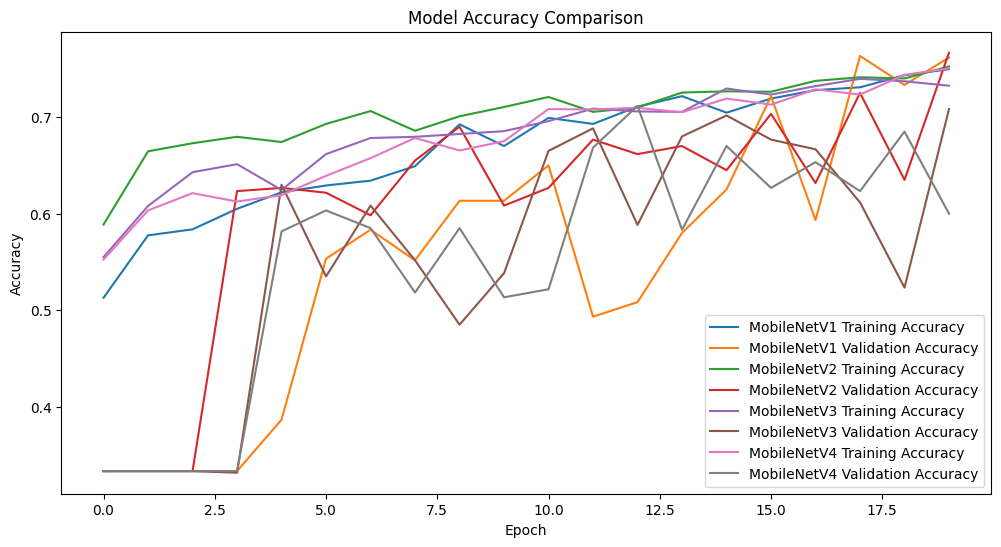

In [18]:
# Plot training vs validation accuracy
plt.figure(figsize=(12, 6))
for history, model_name in zip(history_list, model_names):
    plt.plot(history.history['accuracy'], label=f'{model_name} Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

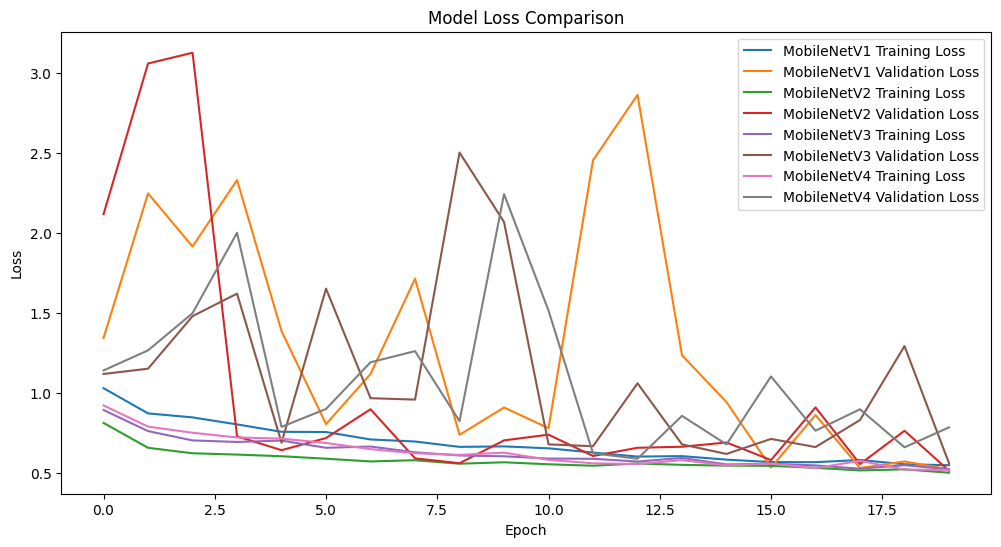

In [19]:
# Plot training vs validation loss
plt.figure(figsize=(12, 6))
for history, model_name in zip(history_list, model_names):
    plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [20]:
# Example for showing training time (already done while training)
for model_name, duration in zip(model_names, training_times):
    print(f"Training Time for {model_name}: {duration:.2f} seconds")

Training Time for MobileNetV1: 2063.86 seconds
Training Time for MobileNetV2: 1538.40 seconds
Training Time for MobileNetV3: 1410.14 seconds
Training Time for MobileNetV4: 1403.94 seconds
